# Computing the energy of metaphosphate on IBM

## Set experiment parameters

In [52]:
ibm_computer: str = "ibm_torino"
qubits = list(range(76, 128 + 1))
for q in [108, 109, 113, 128, 127, 126, 125, 114, 115]:
    _ = qubits.remove(q)
nshots: int = 50_000

len(qubits)

44

## Setup

In [45]:
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import numpy as np
import pickle

import openfermion as of

import qiskit
from qiskit import qasm2, qasm3
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [46]:
# Skip this cell if not running on hardware.
service = qiskit_ibm_runtime.QiskitRuntimeService(name="NERSC-US")
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

## Read in the Hamiltonian and ansatz circuit

In [47]:
data = np.load("hamiltonians/owp_reactant.npz")
print(data)

# Get core energy and one-/two-body tensors
ecore = data['ECORE']
h1 = np.array(data['H1'])
h2 = np.array(data['H2'])
norb = data["NORB"]

# Get number of alpha and beta electrons
n_a = int(data["NELEC"]/2)
n_b = int(data["NELEC"]/2)

h2 = 0.5 * np.asarray(h2.transpose(0, 2, 3, 1), order="C")
h1_new, h2_new = of.chem.molecular_data.spinorb_from_spatial(h1, h2)

# Get the Hamiltonian and transform it to FermionOperator
h = of.InteractionOperator(ecore.item(), h1_new, h2_new)

hamiltonian = of.get_fermion_operator(h)
# hamiltonian.compress(0.001)

nqubits = of.utils.count_qubits(hamiltonian)
nterms = len(hamiltonian.terms)

print(f"Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")

NpzFile 'hamiltonians/owp_reactant.npz' with keys: NORB, NELEC, ECORE, H1, H2
Hamiltonian acts on 44 qubit(s) and has 937977 term(s).


In [48]:
# hamiltonian = of.jordan_wigner(hamiltonian)

In [49]:
nqubits = of.utils.count_qubits(hamiltonian)
nterms = len(hamiltonian.terms)

print(f"Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")

Hamiltonian acts on 44 qubit(s) and has 937977 term(s).


In [50]:
# hamiltonian_cirq = of.qubit_operator_to_pauli_sum(hamiltonian)

In [76]:
circuit_dir = "circuits/"
circuit_fname = "owp_circuit.qasm"
circuit_fname = "owp_circuit_2.qasm"
# circuit_fname = "po3_1w-22o_reactant.qasm"
# circuit_fname = "po3_2w-28o_reactant.qasm"
# circuit_fname = "po3_2w-28o_product.qasm"

In [77]:
circuit = qasm3.load(circuit_dir + circuit_fname)
# circuit.draw(fold=-1)

In [78]:
base = circuit.copy()
base = qiskit.transpiler.passes.RemoveBarriers()(base)

In [79]:
base.count_ops()

OrderedDict([('cx', 292),
             ('ry', 162),
             ('x', 104),
             ('h', 90),
             ('rz', 57),
             ('cz', 6),
             ('rx', 5)])

## Prepare to run on hardware

In [80]:
to_run = base.copy()
to_run = [to_run]

for c in to_run:
    c.measure_all()

In [81]:
to_run = qiskit.transpile(
    to_run,
    optimization_level=3,
    backend=computer,
    initial_layout=qubits,
    seed_transpiler=6
)

In [82]:
for c in to_run:
    print(c.count_ops())

OrderedDict([('sx', 1886), ('cz', 973), ('rz', 752), ('measure', 44), ('x', 11), ('barrier', 1)])


In [83]:
to_run[0].depth()

1059

In [84]:
ops = list(to_run[0].count_ops().keys())
num = list(to_run[0].count_ops().values())

In [85]:
sum([number for op, number in to_run[0].count_ops().items() if op != "cz"])

2694

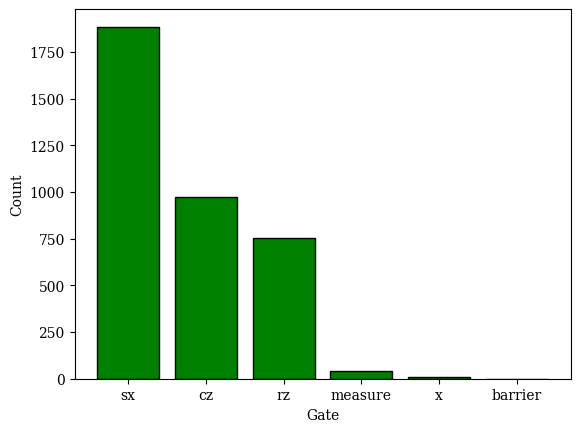

In [86]:
plt.bar(ops, num, color="green", edgecolor="black")
plt.xlabel("Gate")
plt.ylabel("Count");

In [87]:
# to_run[0].draw(fold=-1, idle_wires=False)

## Run on exact simulator

In [88]:
simulator = AerSimulator(method="matrix_product_state")
result = simulator.run(to_run, shots=10)
counts = result.result().get_counts()
counts

{'11111111111111111111111111111111000000000000': 10}

In [89]:
hartree_fock_bitstring = list(counts.keys())[0]
hartree_fock_bitstring

'11111111111111111111111111111111000000000000'

## Run on noisy simulator

In [ ]:
sim = AerSimulator.from_backend(computer, method="matrix_product_state")

In [ ]:
result = sim.run(to_run, shots=nshots)
counts = result.result().get_counts()

In [ ]:
qiskit.visualization.plot_histogram(
    counts,
    target_string=hartree_fock_bitstring,
    sort="hamming",
    number_to_keep=10,
    figsize=(7, 8),
    title=sim.name,
)

In [ ]:
pickle.dump(counts, open(f"owp_counts_{sim.name}.pkl", "wb"))

In [ ]:
counts = pickle.load(open(f"owp_counts_{sim.name}.pkl", "rb"))

## Run on hardware

In [90]:
job = sampler.run(to_run, shots=nshots)
# job = service.job("d4vi5hfg0u6s73daqh3g")

In [91]:
all_counts_hardware = []

In [92]:
res = job.result()

In [93]:
for r in res:
    all_counts_hardware.append(r.data.meas.get_counts())

In [94]:
len(all_counts_hardware[0])

49991

In [95]:
hartree_fock_bitstring in all_counts_hardware[0].keys()

False

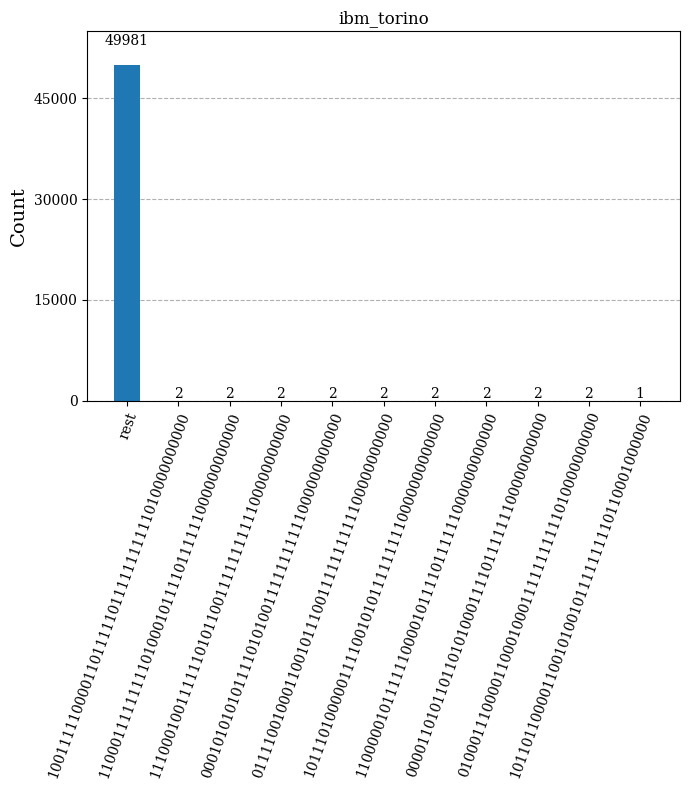

In [96]:
import qiskit.visualization


qiskit.visualization.plot_histogram(
    all_counts_hardware[0],
    target_string=hartree_fock_bitstring,
    sort="hamming",
    number_to_keep=10,
    figsize=(7, 8),
    title=computer.name,
)

## Save data

In [97]:
import datetime


time_key = datetime.datetime.now().strftime("%Y_%m_%d_%H:%M:%S")
fname = circuit_fname + f"_counts_{computer.name}_nshots_{nshots}_{time_key}"
fname

'owp_circuit_2.qasm_counts_ibm_torino_nshots_50000_2025_12_18_22:02:33'

In [98]:
pickle.dump(all_counts_hardware[0], open(fname, "wb"))

## Run SQD

In [40]:
from qiskit.primitives import BitArray

from functools import partial
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

In [105]:
integrals_data = np.load(f'./hamiltonians/owp_reactant.npz', allow_pickle=True)


h1 = integrals_data['H1']
h2 = integrals_data['H2']
n_orbitals = integrals_data['NORB']
num_electrons = integrals_data['NELEC']
ecore = integrals_data['ECORE']

In [106]:
bitstring_counts = bitstrings = pickle.load(open("./results/kingston/owp_counts_ibm_kingston.pkl", "rb"))  # all_counts_hardware[0]
bitstring_counts_rearranged = {}

for bitstr in bitstring_counts:

    # need to convert from alpha, beta, alpha, beta, ... to alpha, alpha, ..., beta, beta, ...
    alpha_bits = [bitstr[int(2*n)] for n in range(n_orbitals)]
    beta_bits = [bitstr[int(2*n)+1] for n in range(n_orbitals)]

    # reverse bits to keep with the convention that qiskit-addon-sqd expects.
    rearranged_bitstr = ''.join(alpha_bits + beta_bits)#[::-1]
    bitstring_counts_rearranged[rearranged_bitstr] = bitstring_counts[bitstr]

bit_array = BitArray.from_counts(bitstring_counts_rearranged)
counts = bit_array.get_counts()
max_key = max(counts, key=counts.get)
print(f'Most common bitstring: {max_key} with count {counts[max_key]}')
print(f'Total number of bitstrings: {len(counts)}')
print(f"Total number of samples:", sum(bitstring_counts.values()))

Most common bitstring: 11111111111111110000001111111111111111000000 with count 18741
Total number of bitstrings: 3871
Total number of samples: 50000


In [109]:
energy_tol = 1e-8
occupancies_tol = 1e-8
carryover_threshold = 1e-5
spin_sq = 0.0
max_davidson_cycles=10**4

nuclear_repulsion_energy = 0.0

samples_per_batch = 10
num_batches = 5

In [111]:
sci_solver = partial(solve_sci_batch, spin_sq=spin_sq, max_cycle=max_davidson_cycles)

result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy + ecore}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")

result = diagonalize_fermionic_hamiltonian(
    one_body_tensor=h1,
    two_body_tensor=h2,
    bit_array=bit_array,
    samples_per_batch=samples_per_batch,
    norb=n_orbitals,
    nelec=(num_electrons // 2, num_electrons // 2),
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=5,
    sci_solver=sci_solver,
    symmetrize_spin=True,
    carryover_threshold=carryover_threshold,
    callback=callback
)

Iteration 1
	Subsample 0
		Energy: -630.8004465796371
		Subspace dimension: 100
	Subsample 1
		Energy: -631.0604303993341
		Subspace dimension: 100
	Subsample 2
		Energy: -630.8201088350395
		Subspace dimension: 100
	Subsample 3
		Energy: -631.1078982265666
		Subspace dimension: 100
	Subsample 4
		Energy: -630.2286516562824
		Subspace dimension: 100
Iteration 2
	Subsample 0
		Energy: -631.1123388986142
		Subspace dimension: 225
	Subsample 1
		Energy: -631.1788038166002
		Subspace dimension: 225
	Subsample 2
		Energy: -632.7204439277789
		Subspace dimension: 196
	Subsample 3
		Energy: -631.1155025901925
		Subspace dimension: 256
	Subsample 4
		Energy: -631.1262213465654
		Subspace dimension: 289
Iteration 3
	Subsample 0
		Energy: -632.7204652865595
		Subspace dimension: 441
	Subsample 1
		Energy: -632.7204672459504
		Subspace dimension: 441
	Subsample 2
		Energy: -632.7939943420897
		Subspace dimension: 529
	Subsample 3
		Energy: -632.7205313619472
		Subspace dimension: 484
	Subsample 4